[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marekadamczyk44/ml_uwr/blob/main/Assignments/Assignment2.3.ipynb)

# Bonus Lab Assignment 2.3 

**Submission deadline:**
* **lab session in the week 20-24.12.21**

**Points: 6 points**

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [4]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [5]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Problem 1 [1-6p]



Let us focus again on linear regression. Recall the two objective functions with which you can measure the fit of your line to the data. Mean Square Error: $\frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2,$ 
and Mean Absolute Error: $\frac{1}{N}\sum_{i=1}^N \left | y^{(i)} - x^{(i)}\Theta \right|$.

Hence you can write the loss function more general $$\frac{1}{N}\sum_{i=1}^N L\left(y^{(i)} - x^{(i)}\Theta\right),$$ where $L(x) = x^2$ for measuring the error for the mean square criterion, and $L(x) = |x|$ for the mean absolute criterion.

Mean Square error criterion works very well if the errors are distributed according to a Gaussian distribution. However, as pointed out in the lecture, it works very poorly in case of the outliers. On the other hand Mean Absolute Error criterion is note affected for the outliers, however it assumes that the errors are distributed according to the Laplace distribution which is not always the case.
The best of both worlds is obtained with Huber loss, where 
$$
L (a) = \begin{cases}
 \frac{1}{2}{a^2}                   & \text{for } |a| \le \delta, \\
 \delta (|a| - \frac{1}{2}\delta), & \text{otherwise.}
\end{cases}
$$ for some parameter $\delta$.
And this idea can also be implemented via pseudo Huber loss of $\delta\left(\sqrt{\left(\frac{x}{\delta}\right)^2 + 1} - 1\right)$.





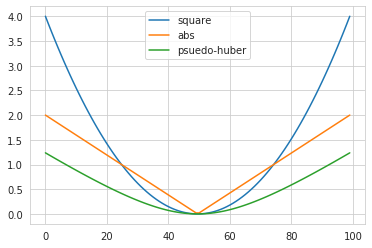

In [6]:
import pandas as pd
import numpy as np

x = np.linspace(-2, 2, 100)
L = pd.DataFrame()
L["square"] = x**2
L["abs"] = abs(x)
L["psuedo-huber"] = np.sqrt(x**2+1)-1 
L.plot()

Hence, it seems like the amount of functions that can be used to model errors in linear regression is very vast, and that's actually the case.

In the paper [General Robust loss function](https://arxiv.org/abs/1701.03077) a function that generalizes all of these functions is presented. 

In [168]:
#filling this cell is part of Task 1

def rho(x, alpha, c): #the general robust loss function
    #print(f"rho {alpha}, {c}:")
    #print(x)
    #print(( ( ( ((x / c) ** 2) / abs( alpha - 2.0 ) ) + 1 ) ) ** (alpha / 2.0) - 1.0)
    if alpha == 2.0:
        return ((x / c) ** 2) / 2
    if alpha == 0.0:
        return np.log( ((x / c) ** 2) / 2 + 1 )
    return (abs( alpha - 2.0 ) / alpha) * ( ( ( ((x / c) ** 2) / abs( alpha - 2.0 ) ) + 1 ) ** (alpha / 2.0) - 1)

def d_rho(x, alpha, c): #and its derivative
    if alpha == 2.0:
        return x / (c * c)
    if alpha == 0.0:
        return (2 * x) / (x ** 2 + 2 * (c ** 2) )
    return (x / (c * c)) * ( ( ( (x/c ** 2) / abs( alpha - 2 ) ) + 1 ) ** (alpha / 2.0 - 1) )



The function $\rho$ is parametrized with $\alpha$ and $c$. Different values of $\alpha$ correspond to different shapes of the function:


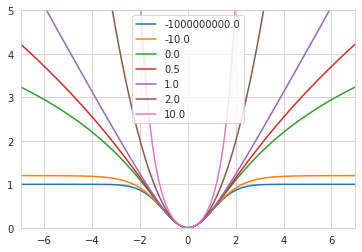

In [169]:
x = np.linspace(-7, 7, 100)
R = pd.DataFrame(index=x)
for alpha in [-1e+9, -10, 0, 0.5, 1., 2., 10.]:
    R[alpha] = rho(x, alpha, c=1.)
R.plot(xlim=(-7,7),ylim=(0,5))

## Task 1 [1p]
Implement the $\rho$ function from the paper, and its derivative.

## Task 2 [1p]

For different values of $alpha$ (and $c=1$) fit $\rho(\cdot,alpha,c)$ into the house dataset

In [156]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/janchorowski/nn_assignments/nn18/assignment3/03-house-prices-outliers.csv",
    index_col=0,
)
data.head()

,rooms,area,price
0,3,66.80,367.801
1,3,55.03,289.458
2,4,70.80,389.000
3,1,29.02,195.695
4,2,45.76,265.754


In [157]:
X = np.stack((np.ones_like(data.area), data.area)).T
Y = np.asarray(data.price)
X, Y

(array([[ 1.  , 66.8 ],
        [ 1.  , 55.03],
        [ 1.  , 70.8 ],
        ...,
        [ 1.  , 46.7 ],
        [ 1.  , 50.41],
        [ 1.  , 48.1 ]]),
 array([367.801, 289.458, 389.   , ..., 266.   , 267.1  , 269.   ]))

In [166]:
def linreg_general_loss(Theta, X, Y, alpha, c):
#TODO
    #print(Theta)
    #print(X)
    #print(Y)
    Z = X @ Theta
    #print(Z)
    loss = np.sum(rho(Y - Z, alpha, c)) / Z.shape[0]
    print(rho(Y - Z, alpha, c))
    print(f"loss:{loss}")
    grad = X.T @ rho(Y - Z, alpha, c)
    print(f"grad:{grad}")
    
    return loss, grad.reshape(Theta.shape)

rho -1.999999999, 1.0:
[-0.99995614 -0.99992784 -0.99996074 ... -0.99991759 -0.9999156
 -0.99991877]
rho -1.999999999, 1.0:
[-0.99995614 -0.99992784 -0.99996074 ... -0.99991759 -0.9999156
 -0.99991877]
[1.99991229 1.99985568 1.99992149 ... 1.99983517 1.9998312  1.99983754]
loss:1.9998773587168466
rho -1.999999999, 1.0:
[-0.99995614 -0.99992784 -0.99996074 ... -0.99991759 -0.9999156
 -0.99991877]
grad:[ 11839.2739636  705372.25135609]
rho -1.999999999, 1.0:
[-0.99997059 -0.99995259 -0.9999737  ... -0.9999439  -0.99994436
 -0.99994514]
rho -1.999999999, 1.0:
[-0.99997059 -0.99995259 -0.9999737  ... -0.9999439  -0.99994436
 -0.99994514]
[1.99994119 1.99990519 1.99994741 ... 1.9998878  1.99988871 1.99989028]
loss:1.9999164167671097
rho -1.999999999, 1.0:
[-0.99997059 -0.99995259 -0.9999737  ... -0.9999439  -0.99994436
 -0.99994514]
grad:[ 11839.50518726 705384.10836631]
rho -1.999999999, 1.0:
[-0.99995997 -0.99993447 -0.99996418 ... -0.9999245  -0.99992329
 -0.99992573]
rho -1.999999999, 1

rho -0.999999999, 1.0:
[-0.99427679 -0.99265936 -0.99458518 ... -0.9921537  -0.99206109
 -0.99221062]
[2.98283036 2.97797807 2.98375556 ... 2.97646109 2.97618328 2.97663186]
loss:2.980706978193617
rho -0.999999999, 1.0:
[-0.99427679 -0.99265936 -0.99458518 ... -0.9921537  -0.99206109
 -0.99221062]
grad:[  17645.78531091 1051869.03485482]
rho -0.999999999, 1.0:
[-0.99426737 -0.9926466  -0.99457625 ... -0.99214133 -0.99204742
 -0.99219806]
rho -0.999999999, 1.0:
[-0.99426737 -0.9926466  -0.99457625 ... -0.99214133 -0.99204742
 -0.99219806]
[2.98280212 2.97793979 2.98372876 ... 2.97642398 2.97614227 2.97659419]
loss:2.980677004270082
rho -0.999999999, 1.0:
[-0.99426737 -0.9926466  -0.99457625 ... -0.99214133 -0.99204742
 -0.99219806]
grad:[  17645.60786528 1051859.20716153]
rho -0.999999999, 1.0:
[-0.99426538 -0.99264389 -0.99457436 ... -0.99213871 -0.99204453
 -0.9921954 ]
rho -0.999999999, 1.0:
[-0.99426538 -0.99264389 -0.99457436 ... -0.99213871 -0.99204453
 -0.9921954 ]
[2.98279614 2.

[5.36591771e-09 5.11701592e-09 5.42130962e-09 ... 5.05040210e-09
 5.03866571e-09 5.05768272e-09]
[10.73183541 10.23403184 10.84261924 ... 10.10080419 10.07733141
 10.11536543]
loss:10.615971551623621
rho 1e-09, 1.0:
[5.36591771e-09 5.11701592e-09 5.42130962e-09 ... 5.05040210e-09
 5.03866571e-09 5.05768272e-09]
grad:[  62846.55158561 3811392.10740842]
rho 1e-09, 1.0:
[5.36430123e-09 5.11530773e-09 5.41968870e-09 ... 5.04885267e-09
 5.03697350e-09 5.05609843e-09]
rho 1e-09, 1.0:
[5.36430123e-09 5.11530773e-09 5.41968870e-09 ... 5.04885267e-09
 5.03697350e-09 5.05609843e-09]
[10.72860245 10.23061546 10.83937739 ... 10.09770533 10.073947
 10.11219685]
loss:10.612998203180773
rho 1e-09, 1.0:
[5.36430123e-09 5.11530773e-09 5.41968870e-09 ... 5.04885267e-09
 5.03697350e-09 5.05609843e-09]
grad:[  62828.94936283 3810335.54277949]
rho 1e-09, 1.0:
[5.36395928e-09 5.11494647e-09 5.41934608e-09 ... 5.04852515e-09
 5.03661557e-09 5.05576336e-09]
rho 1e-09, 1.0:
[5.36395928e-09 5.11494647e-09 5.419

rho 1.000000001, 1.0:
[314.14181532 245.254678   332.12733324 ... 228.48872453 226.60831722
 230.36401809]
rho 1.000000001, 1.0:
[314.14181532 245.254678   332.12733324 ... 228.48872453 226.60831722
 230.36401809]
[314.14181469 245.25467751 332.12733258 ... 228.48872407 226.60831677
 230.36401763]
loss:327.7653933856308
rho 1.000000001, 1.0:
[314.14181532 245.254678   332.12733324 ... 228.48872453 226.60831722
 230.36401809]
grad:[1.94037113e+06 1.29366985e+08]
rho 1.000000001, 1.0:
[303.73939629 236.68475749 321.10214865 ... 221.2157056  218.75769299
 222.8730332 ]
rho 1.000000001, 1.0:
[303.73939629 236.68475749 321.10214865 ... 221.2157056  218.75769299
 222.8730332 ]
[303.73939568 236.68475702 321.10214801 ... 221.21570516 218.75769255
 222.87303275]
loss:318.48730309655195
rho 1.000000001, 1.0:
[303.73939629 236.68475749 321.10214865 ... 221.2157056  218.75769299
 222.8730332 ]
grad:[1.88544483e+06 1.25721131e+08]
rho 1.000000001, 1.0:
[301.57924949 234.90514417 318.81267947 ... 2

rho 2.000000001, 1.0:
[9.12207616e+13 5.54367204e+13 1.01906740e+14 ... 4.85403306e+13
 4.73977260e+13 4.92481592e+13]
grad:[1.50757094e+09 1.00857874e+11]
rho 2.000000001, 1.0:
[9.12080135e+13 5.54285331e+13 1.01892459e+14 ... 4.85338288e+13
 4.73907910e+13 4.92414140e+13]
rho 2.000000001, 1.0:
[9.12080135e+13 5.54285331e+13 1.01892459e+14 ... 4.85338288e+13
 4.73907910e+13 4.92414140e+13]
[45604.01051869 27714.26883032 50946.23392788 ... 24266.91638844
 23695.39746568 24620.70901338]
loss:254650.57639862588
rho 2.000000001, 1.0:
[9.12080135e+13 5.54285331e+13 1.01892459e+14 ... 4.85338288e+13
 4.73907910e+13 4.92414140e+13]
grad:[1.50753141e+09 1.00854792e+11]
rho 2.000000001, 1.0:
[9.12053197e+13 5.54268030e+13 1.01889442e+14 ... 4.85324549e+13
 4.73893256e+13 4.92399886e+13]
rho 2.000000001, 1.0:
[9.12053197e+13 5.54268030e+13 1.01889442e+14 ... 4.85324549e+13
 4.73893256e+13 4.92399886e+13]
[45602.663609   27713.40379803 50944.72508403 ... 24266.22943608
 23694.66474132 24619.9963

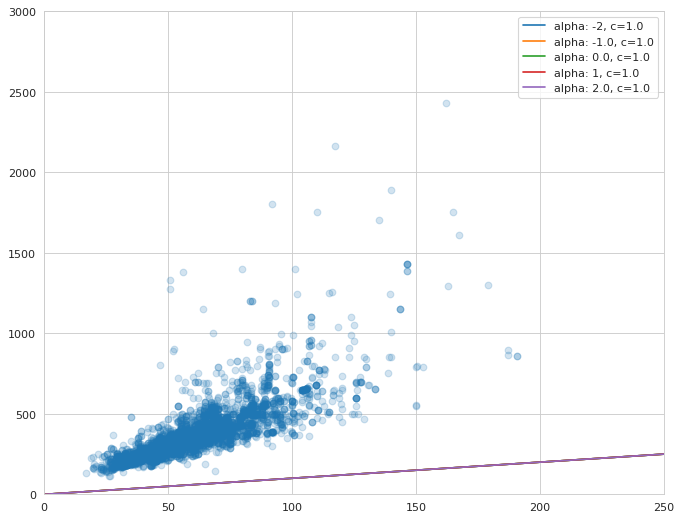

In [167]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

plt.scatter(X[:,1], Y, alpha=0.2)
area = np.linspace(0,400,1000)
Theta0 = np.asarray([-1,1])

for alpha in [-2,-1., 0., 1, 2.]:
    for c in [1.]:
        ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
            lambda Theta: linreg_general_loss(Theta, X, Y, alpha=alpha+1e-9, c=c), np.array(Theta0)
        )
        price = ThetaOpt[1] * area + ThetaOpt[0]
        plt.plot(area, price, label=f"alpha: {alpha}, c={c}")

plt.xlim(0, 250)  # xlim_area[1])
plt.ylim(0, 3000)
plt.legend()


## Task 3 [1p]

As you can see in the plot above, different $\alpha$'s yield different lines. A natural question pops up: which $\alpha$ is the best?
But what does "best" even mean here? How we can quantitatively compare $\alpha$'s? Measuring the fit to the data of every line with a measure of form $$\frac{1}{N}\sum_{i=1}^N some-measure-function(y^{(i)} - x^{(i)}\Theta)$$
doesn't really make sense now.

However, we can look at it from the point of view of MLE estimators. 

As we have seen in the lecture, mean square error criterion which uses $x \mapsto x^2$ as an error measuring function corresponds to MLE under assumption that the errors are distributed according to a zero-mean normal distribution. In other words when the data $X,y$ we have was really generated by a random process such that $y_i = \Theta\cdot x_i + N(0,\sigma)$ for some $\Theta$ and some $\sigma$. And it happens that the probability density function of a normal distribution $N(0, \sigma)$ is $\frac{1}{\sigma}e^{-\frac{1}{2}\frac{x^2}{\sigma}}$

One can reproduce the proof that minimizing MSE finds MLE for normal distributions to get the proof that if the errors are distributed according to $$\frac{1}{c\cdot Z(\alpha)}e^{-\rho(x, \alpha, c)},$$ 
i.e., data is generated as $y_i = \Theta\cdot x_i + error_i$ with $error_i$ being a random variable whose probability density function is $\frac{1}{c\cdot Z(\alpha)}e^{-\rho(x, \alpha, c)}$. $Z(\alpha)$ here is a normalization constant which makes the density function integrate to $1$, that is, $Z(\alpha) = \int_{-\infty}^\infty e^{-\rho(x, \alpha, c)} \mbox{d}x$.

Reproduce this proof to get 1 point.

## Task 4 [1 vs 3p]

So now we have a clear criterion for comparing $alpha$'s. Add $\alpha$ as a parameter to the  training and find $\alpha$ and corresponding $\Theta$ that minimizes the negative log likelihood. Keep $c$ equal to $1$ everywhere, although this also can be tunable in general.

You will get 3 points if you will compute the derivative of $\rho$ over $\alpha$ and use is it in the gradient for fmin_l_bfgs_b

You will get 1 point if you will do a search over space of $alpha$'s, for every $\alpha$ you will use fmin_l_bfgs_b only for $\Theta$ and find the pair $\alpha$, $\Theta$ which maximizes the NLL.

**Note** that $Z(\alpha)$ needs to be computed in the gradient, so you will need to compute the integral $\int_{-\infty}^\infty e^{-\rho(x, \alpha, c)} \mbox{d}x$.